In [10]:
import sys

sys.path.append("/Users/kanishkjain/opt/anaconda3/envs/gym/lib/python3.9/site-packages")

import random
import collections
from pprint import pprint

import gym
import gym_toytext
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter1d

In [53]:
class Agent:
    def __init__(
        self, environment="Roulette-v0"
    ) -> None:

        self.environment = environment

    def epsilon_greedy_policy(self, Pi, epsilon):
        
        Pi = np.around(Pi, decimals=1)

        p = np.random.rand()
        Num_A = len(Pi)
        if p < epsilon:
            return np.random.choice(Num_A)
        else:
            a_star = np.max(Pi)
            max_indices = [i for i in range(Num_A) if Pi[i]==a_star]
            A = np.random.choice(max_indices)
            return A
    
    def soft_policy(self, Num_A):
        A = np.random.choice(Num_A)
        return A
    
    def on_policy_monte_carlo(self, num_iter=30000, alpha=0.5,  gamma=0.6, epsilon = 0.7):

        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n
        env.reset()

        NUM_ITER = num_iter

        Q = np.zeros((Num_S, Num_A))
        C = np.zeros((Num_S, Num_A))
        rewards = np.zeros(NUM_ITER)

        Pi = np.ones((Num_S, Num_A))/Num_A
        
        returns = collections.defaultdict(list)

        for it in range(1, NUM_ITER + 1):
            if it % 5000 == 0:
                print(f"Generating Episode Number: {it}")
                
            S = env.reset()
            
            G = 0
            step = 0
            episode = []
            while True:
                if np.random.rand() < epsilon:
                    A = np.random.choice(Num_A)
                else:
                    a_star = np.max(Pi[S])
                    max_indices = [i for i in range(Num_A) if Pi[S, i]==a_star]
                    A = np.random.choice(max_indices)
            
                S_, R, terminal, _ = env.step(A)
                
                if not terminal:
                    R = -1
                
                episode.append((S, A, R))
                
                G = G + (gamma**step)*R

                S = S_
                
                step+=1

                if terminal:
                    break
                    
            rewards[it - 1] = G

            S_A = [(S, A) for (S, A, _) in episode]
            
            G = 0
            t = len(episode) - 1
            while t >= 0:
                S, A, R = episode[t]
                G = G + R
                if not (S, A) in S_A[:t]:
                    returns[(S, A)].append(G)
                    Q[S, A] = sum(returns[(S, A)])/len(returns[(S, A)])
                    
                    q_max = np.max(Q[S])
                    max_indices = [i for i in range(Num_A) if Q[S, i]==q_max]
                    A_star = np.random.choice(max_indices)
                    
                    for a in range(Num_A):
                        if a == A_star:
                            Pi[S, a] = 1 - epsilon + (epsilon/Num_A)
                        else:
                            Pi[S, a] = (epsilon/Num_A)
                t-=1
                
        return Q, rewards
    
    def off_policy_monte_carlo(self, num_iter=50000, alpha=0.05, gamma=0.0, epsilon = 0.1):

        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n
        env.reset()

        NUM_ITER = num_iter

        # Q = np.random.rand(Num_S, Num_A)
        Q = np.zeros((Num_S, Num_A))
        C = np.zeros((Num_S, Num_A))
        rewards = np.zeros(NUM_ITER)

        for it in range(1, NUM_ITER + 1):
            if it % 5000 == 0:
                print(f"Generating Episode Number: {it}")

            S = env.reset()
            
            G = 0
            step = 0
            episode = []
            while True:    
                A = np.random.choice(Num_A)
                S_, R, terminal, _ = env.step(A)
                
                if not terminal:
                    R = -1
                
                episode.append((S, A, R))
                
                G = G + (gamma**step)*R

                S = S_
                
                step+=1

                if terminal:
                    break
                    
            rewards[it - 1] = G
            
            G = 0.
            W = 1.
            t = len(episode) - 1
            while t >= 0:
                S, A, R = episode[t]
                
                G = gamma * G + R
                
                C[S, A] += W
                Q[S, A] += (W/C[S, A]) * (G - Q[S, A])
                
                q_max = np.max(Q[S])
                max_indices = [i for i in range(Num_A) if Q[S, i]==q_max]
                if A in max_indices:
                    A_star = A
                else:
                    A_star = np.random.choice(max_indices)
                
                if A!=A_star:
                    break
                W = W * (1/(1/Num_A))
                
                t -= 1

        return Q, rewards
    
    def q_learning(self, num_iter=30000, alpha=0.1, gamma=0.9, epsilon = 0.05):

        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n
        env.reset()

        NUM_ITER = num_iter

        Q = np.zeros((Num_S, Num_A))
        rewards = np.zeros(NUM_ITER)

        for it in range(1, NUM_ITER + 1):

            if it % 5000 == 0:
                print(f"Generating Episode Number: {it}")

            S = env.reset()
            
            G = 0
            step = 0
            while True:
                A = self.epsilon_greedy_policy(Q[S], epsilon)
                S_, R, terminal, _ = env.step(A)
                
                if not terminal:
                    R = -1
                
                G = G + (gamma**step)*R

                Q[S][A] += alpha * (R + gamma * np.max(Q[S_]) - Q[S][A])

                S = S_
                
                step+=1

                if terminal:
                    break
                    
            rewards[it -1] = G

        return Q, rewards

    def sarsa(self, num_iter=30000, alpha=0.1, gamma=0.9, epsilon = 0.05):

        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n
        env.reset()

        NUM_ITER = num_iter

        Q = np.zeros((Num_S, Num_A))
        rewards = np.zeros(NUM_ITER)

        for it in range(1, NUM_ITER + 1):
            if it % 5000 == 0:
                print(f"Generating Episode Number: {it}")

            S = env.reset()
            A = self.epsilon_greedy_policy(Q[S], epsilon)
            
            G = 0
            step = 0
            while True:
                S_, R, terminal, _ = env.step(A)
                A_ = self.epsilon_greedy_policy(Q[S_], epsilon)
                
                if not terminal:
                    R = -1
                
                G = G + (gamma**step)*R

                Q[S][A] = Q[S][A] + alpha * (R + gamma * Q[S_][A_] - Q[S][A])

                S = S_
                A = A_
                
                step += 1

                if terminal:
                    break
            rewards[it -1] = G

        return Q, rewards

    def show_policy(self, Q):

        MAX_STEPS = 51
        
        env = gym.make(self.environment)
        Num_A = env.action_space.n
        Num_S = env.observation_space.n

        S = env.reset()
        print(f"Starting state: {S}")

        step = 0
        done = False
        while step < MAX_STEPS:
            A = np.argmax(Q[S])
            # env.render()
            S_, R, done, _ = env.step(A)
            if done:
                break
            print(
                f"Current State: {S}, action: {A}, reward: {R}, terminal: {done}, step: {step}"
            )
            S = S_
            step += 1
        if done:
            print(
                f"Current State: {S}, action: {A}, reward: {R}, terminal: {done}, step: {step}"
            )
            # env.render()
        env.close()
        print("Finished", done)

In [54]:
agent = Agent(environment='Roulette-v0')

In [70]:
on_policy_Q, on_policy_rewards = agent.on_policy_monte_carlo(num_iter=3000, alpha=0.5,  gamma=0.9, epsilon = 0.05)
agent.show_policy(on_policy_Q)
on_policy_rewards = gaussian_filter1d(on_policy_rewards, sigma=10)

Starting state: 0
Current State: 0, action: 37, reward: 0, terminal: True, step: 0
Finished True


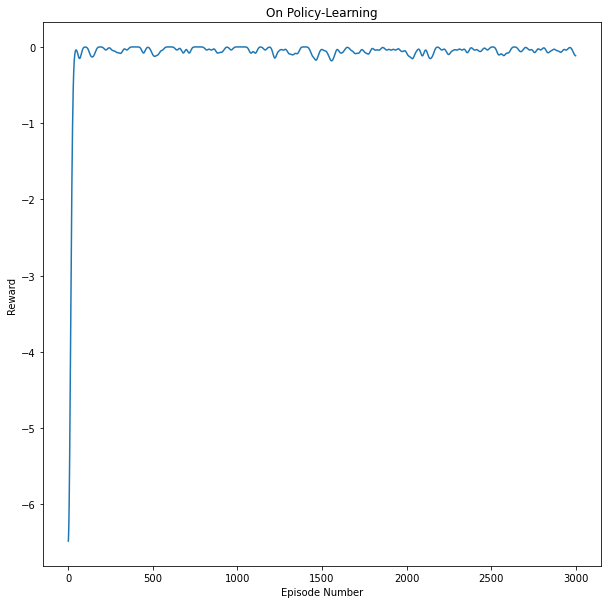

In [71]:
fig = plt.figure(figsize=(10, 10))
plt.plot(on_policy_rewards)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('On Policy-Learning')
plt.show()

In [75]:
off_policy_Q, off_policy_rewards = agent.off_policy_monte_carlo(num_iter=3000, alpha=0.9, gamma=0.9, epsilon = 0.05)
agent.show_policy(off_policy_Q)
off_policy_rewards = gaussian_filter1d(off_policy_rewards, sigma=10)

Starting state: 0
Current State: 0, action: 37, reward: 0, terminal: True, step: 0
Finished True


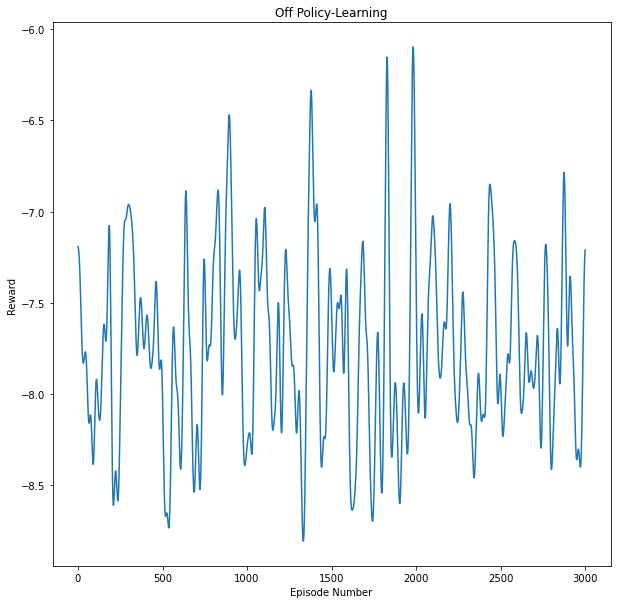

In [76]:
fig = plt.figure(figsize=(10, 10))
plt.plot(off_policy_rewards)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('Off Policy-Learning')
plt.show()

In [77]:
q_policy, q_rewards = agent.q_learning(num_iter=3000, alpha=0.1, gamma=0.9, epsilon = 0.05)
agent.show_policy(q_policy)
q_rewards = gaussian_filter1d(q_rewards, sigma=10)

Starting state: 0
Current State: 0, action: 37, reward: 0, terminal: True, step: 0
Finished True


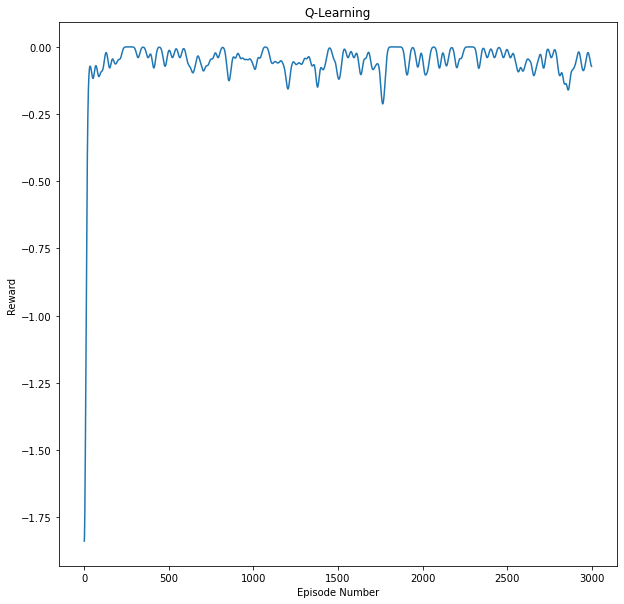

In [78]:
fig = plt.figure(figsize=(10, 10))
plt.plot(q_rewards)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('Q-Learning')
plt.show()

In [79]:
sarsa_policy, sarsa_rewards = agent.sarsa(num_iter=3000, alpha=0.1, gamma=0.9, epsilon = 0.05)
agent.show_policy(sarsa_policy)
sarsa_rewards = gaussian_filter1d(sarsa_rewards, sigma=10)

Starting state: 0
Current State: 0, action: 37, reward: 0, terminal: True, step: 0
Finished True


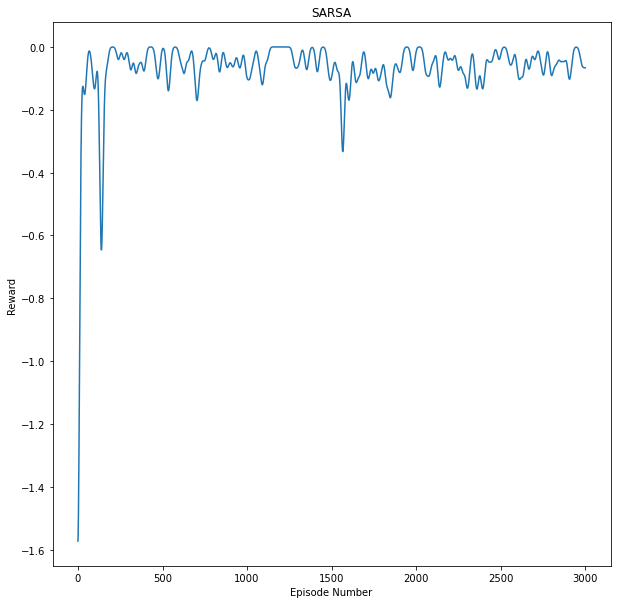

In [80]:
fig = plt.figure(figsize=(10, 10))
plt.plot(sarsa_rewards)
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('SARSA')
plt.show()

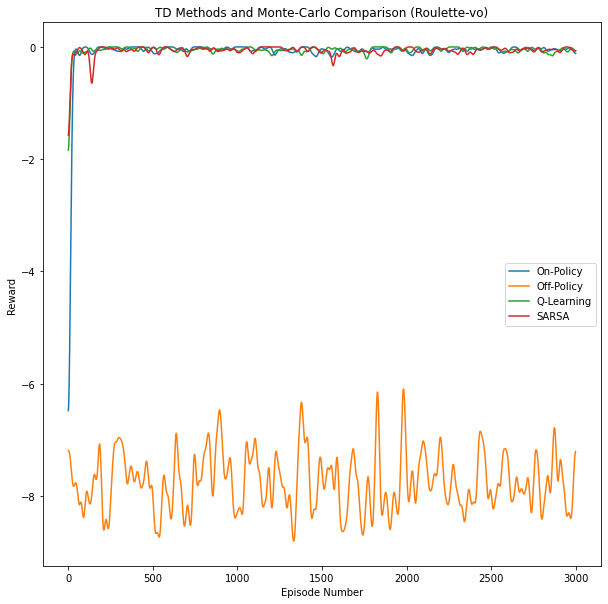

In [81]:
fig = plt.figure(figsize=(10, 10))

plt.plot(on_policy_rewards, label="On-Policy")
plt.plot(off_policy_rewards, label="Off-Policy")
plt.plot(q_rewards, label="Q-Learning")
plt.plot(sarsa_rewards, label="SARSA")

plt.legend()
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('TD Methods and Monte-Carlo Comparison (Roulette-vo)')
plt.show()

Both TD methods and On-Policy Monte Carlo performed better compared to Off_policy Monte Carlo as they were able to converge to optimal policy faster than Off-policy Monte Carlo. TD Methods, Q-learning and SARA were able to converge to best policy within first 10-15 episodes, On-Policy converged to best policy within 25-30 episodes. Since, Qff-Policy uses random soft policy for episode generation, the number of episodes it took to learn best policy cannot be determined from graph like other methods.